In [ ]:
pip install scikit-learn

In [17]:
import os
import shutil
from sklearn.model_selection import train_test_split

train_dir = "../bisindo/images/train"
test_dir = "../bisindo/images/test"

os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    # pastikan ini folder
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)

    # split 15% per kelas
    train_imgs, test_imgs = train_test_split(
        images,
        test_size=0.15,
        random_state=42
    )

    # buat folder kelas di test
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # pindahkan gambar test
    for img in test_imgs:
        shutil.move(
            os.path.join(class_path, img),
            os.path.join(test_dir, class_name, img)
        )

In [3]:
pip install tensorflow

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl (331.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# ===============================
# CONFIG
# ===============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ===============================
# DATAGEN KHUSUS RESNET
# ===============================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# ===============================
# GENERATOR
# ===============================
train_gen = train_datagen.flow_from_directory(
    "../bisindo/images/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    "../bisindo/images/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    "../bisindo/images/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # WAJIB untuk evaluasi
)


Found 7782 images belonging to 26 classes.
Found 2301 images belonging to 26 classes.
Found 1387 images belonging to 26 classes.


In [14]:
num_classes = train_gen.num_classes  # harus 26
class_names = list(train_gen.class_indices.keys())
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [15]:
import json

class_indices = train_gen.class_indices
print(class_indices)

with open("../modelling/label_resnet.json", "w") as f:
    json.dump(class_indices, f)


{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [17]:
resnet_model = Model(
    inputs=base_model.input,
    outputs=output
)

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history_resnet = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

c:\Users\Acer\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1194s 5s/step - accuracy: 0.3960 - loss: 2.2670 - val_accuracy: 0.8444 - val_loss: 0.5987
Epoch 2/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1136s 5s/step - accuracy: 0.7766 - loss: 0.7668 - val_accuracy: 0.8835 - val_loss: 0.4023
Epoch 3/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1140s 5s/step - accuracy: 0.8346 - loss: 0.5446 - val_accuracy: 0.9083 - val_loss: 0.3102
Epoch 4/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1122s 5s/step - accuracy: 0.8625 - loss: 0.4339 - val_accuracy: 0.9179 - val_loss: 0.2822
Epoch 5/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1124s 5s/step - accuracy: 0.8784 - loss: 0.3712 - val_accuracy: 0.9187 - val_loss: 0.2386
Epoch 6/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1153s 5s/step - accuracy: 0.9037 - loss: 0.2939 - val_accuracy: 0.9305 - val_loss: 0.2067
Epoch 7/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1123s 5s/step - accuracy: 0.9078 - loss: 0.2780 - val_accuracy: 0.9448 - val_loss: 0.1768
Epoch 8/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1125s 5s/step - accuracy: 0.9127 - loss: 0.2625 - 

In [19]:
import tensorflow as tf

# Buka 10 layer terakhir
for layer in base_model.layers[-10:]:
    layer.trainable = True

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # LR kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_resnet_ft = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

Epoch 1/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1303s 5s/step - accuracy: 0.9240 - loss: 0.2240 - val_accuracy: 0.9587 - val_loss: 0.1178
Epoch 2/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1301s 5s/step - accuracy: 0.9681 - loss: 0.1043 - val_accuracy: 0.9591 - val_loss: 0.1088
Epoch 3/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1302s 5s/step - accuracy: 0.9757 - loss: 0.0781 - val_accuracy: 0.9665 - val_loss: 0.1008
Epoch 4/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1315s 5s/step - accuracy: 0.9717 - loss: 0.0825 - val_accuracy: 0.9687 - val_loss: 0.0956
Epoch 5/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1283s 5s/step - accuracy: 0.9866 - loss: 0.0528 - val_accuracy: 0.9704 - val_loss: 0.0910
Epoch 6/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1288s 5s/step - accuracy: 0.9803 - loss: 0.0595 - val_accuracy: 0.9687 - val_loss: 0.0850
Epoch 7/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1280s 5s/step - accuracy: 0.9853 - loss: 0.0483 - val_accuracy: 0.9718 - val_loss: 0.0850
Epoch 8/15
244/244 ━━━━━━━━━━━━━━━━━━━━ 1293s 5s/step - accuracy: 0.9852 - loss: 0.0467 - 

In [20]:
!pip install scikit-learn

In [21]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_resnet = np.argmax(resnet_model.predict(test_gen), axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("=== Classification Report ResNet ===")
print(classification_report(
    y_true,
    y_pred_resnet,
    target_names=class_names
))

44/44 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step
=== Classification Report ResNet ===
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        53
           B       1.00      0.98      0.99        53
           C       0.98      0.98      0.98        52
           D       0.98      0.92      0.95        53
           E       1.00      1.00      1.00        53
           F       0.98      1.00      0.99        54
           G       1.00      1.00      1.00        54
           H       0.96      0.98      0.97        53
           I       0.98      0.98      0.98        54
           J       0.95      0.96      0.95        54
           K       0.95      0.98      0.96        53
           L       0.98      0.94      0.96        54
           M       0.98      0.91      0.94        54
           N       0.91      0.98      0.95        53
           O       1.00      1.00      1.00        54
           P       0.95      1.00      0.97        54
    

In [22]:
!pip install seaborn
!pip install matplotli

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 3.3 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/7.8 MB 3.4 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/7.8 MB 3.4 MB/s eta 0:00:02
   ------------- -------------------------- 2.6/7.8 MB 3.1 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/7.8 MB 3.5 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/7.8 MB 3.4 MB/s eta 0:00:01
   -------------------------- ------------- 5.2/7.8 MB 3.6 MB/s eta 0:00:01
   --------------

ERROR: Could not find a version that satisfies the requirement matplotli (from versions: none)
ERROR: No matching distribution found for matplotli


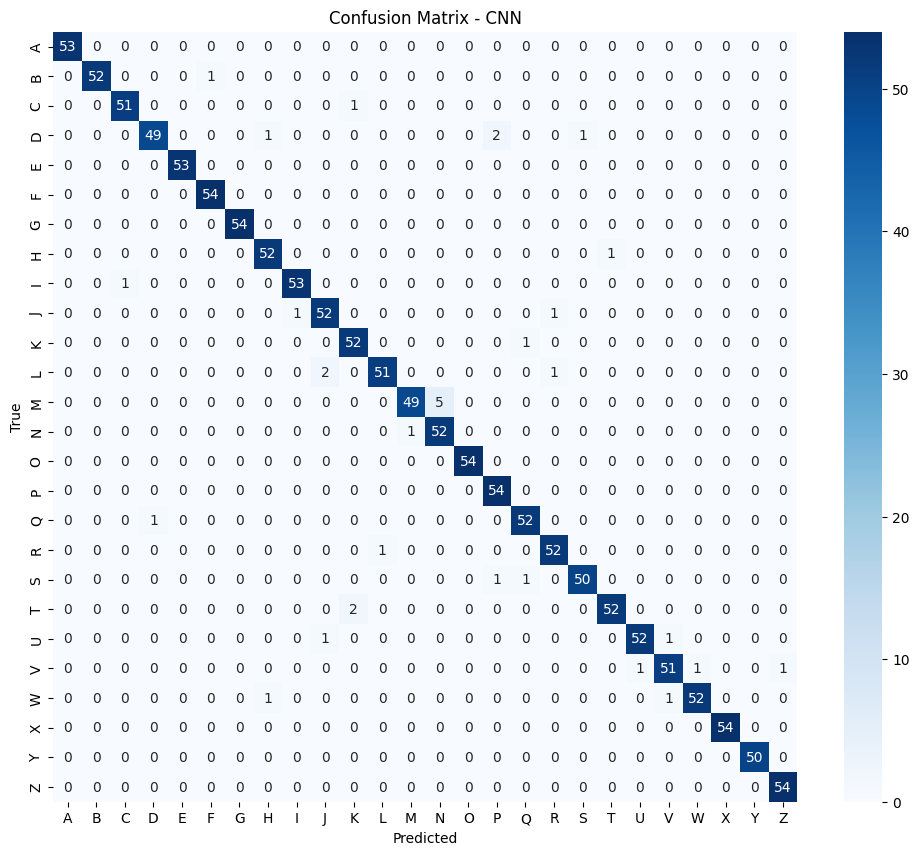

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_resnet)

plt.figure(figsize=(12,10))
sns.heatmap(
    cm,
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
    annot=True
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN")
plt.show()


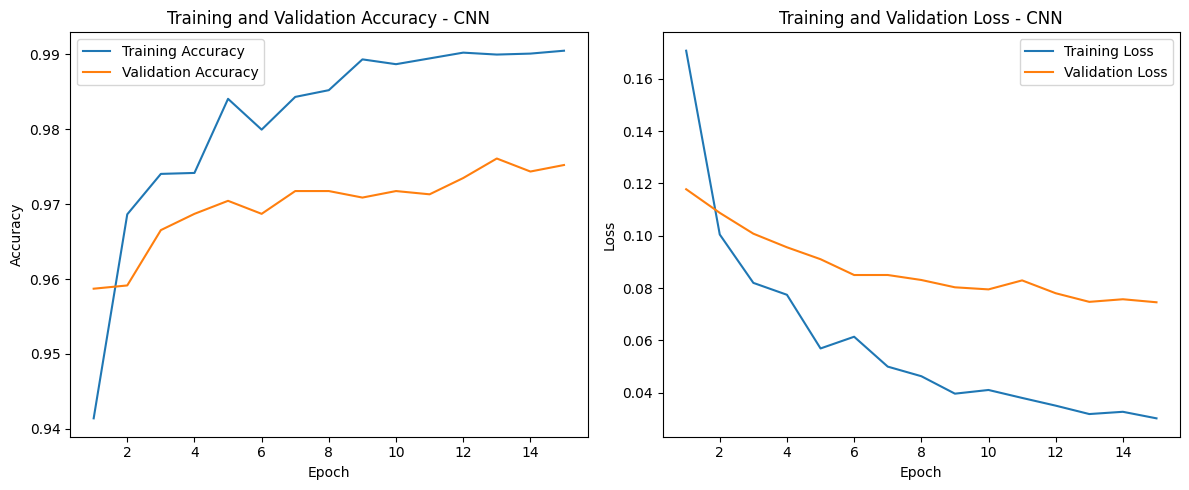

In [24]:
import matplotlib.pyplot as plt

# Ambil data dari history
acc = history_resnet_ft.history['accuracy']
val_acc = history_resnet_ft.history['val_accuracy']
loss = history_resnet_ft.history['loss']
val_loss = history_resnet_ft.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Grafik Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy - CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Grafik Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss - CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
resnet_model.save("../modelling/resnet_model.h5")
resnet_model.save("../modelling/resnet_model.keras")